# Movie Mate: Find Your Next Cinematic Match

## Objective: Build and evaluate recommendation engines to predict user movie preferences.

### Introduction

Ditch the endless scrolling! Our data-powered engine finds your next cinematic soulmate based on your unique movie taste.

Our objective is to leverage the power of data science to build intelligent recommendation engines that can predict which superhero movies you'll enjoy the most. By analyzing your movie preferences and incorporating the "Batman vs. Superman" theme, we aim to create a personalized recommendation experience that caters to your specific tastes.

The cornerstone of our recommendation system is the MovieLens dataset. This renowned dataset provides a treasure trove of user ratings for countless movies across various genres. The richness of this data allows us to understand user preferences and identify patterns that can be harnessed for movie recommendations.

Get ready to embark on a thrilling journey as we explore the intersection of data science and superhero fandom!

### Data Preparation

#### Looking at the columns

In [3]:
import pandas as pd

folder_path = "./data"
file_names = ["tag", "rating", "movie", "link", "genome_tags", "genome_scores"]

print("Columns in each data source:")

for file_name in file_names:
    df = pd.read_csv(folder_path + "/" + file_name + ".csv")
    print("File name: " + file_name)
    print(df.head())

Columns in each data source:
File name: tag
   userId  movieId            tag            timestamp
0      18     4141    Mark Waters  2009-04-24 18:19:40
1      65      208      dark hero  2013-05-10 01:41:18
2      65      353      dark hero  2013-05-10 01:41:19
3      65      521  noir thriller  2013-05-10 01:39:43
4      65      592      dark hero  2013-05-10 01:41:18
File name: rating
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40
File name: movie
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

  

I will use the following data for the 3 approaches, 

1. Collaborative (user based): movie rating data
2. Collaborative (movie based): movie rating data
3. Content based : genome scores data

#### Checking for missing or incomplete data

##### Movie rating data

In [1]:
import pandas as pd

data_path = "./data/rating.csv"
rating_df = pd.read_csv(data_path)
print(rating_df.head())

   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


Questions i'm concerned with:
1. What is the total number of movies?
2. What is the total number of users?
3. What is the average number of movies rated by a user?
4. What is the average number of ratings per movie?

In [3]:
print(rating_df.nunique())

userId         138493
movieId         26744
rating             10
timestamp    15351121
dtype: int64


In [9]:
user_movie_count = rating_df.groupby('userId')['movieId'].nunique()
print(user_movie_count.describe())

count    30780.000000
mean       125.001527
std        194.073437
min          1.000000
25%         29.000000
50%         60.000000
75%        139.000000
max       4354.000000
Name: movieId, dtype: float64


In [10]:
movie_user_count = rating_df.groupby('movieId')['userId'].nunique()
print(movie_user_count.describe())

count    26302.000000
mean       146.283439
std        592.830393
min          1.000000
25%          2.000000
50%          8.000000
75%         44.000000
max      14023.000000
Name: userId, dtype: float64


### Collaborative Filtering

##### User-based Collaborative Filtering (CF):

<b>Concept:</b> User-based CF identifies users with similar taste in movies (neighbors) and recommends movies those neighbors enjoyed but the target user hasn't seen yet. These neighbours can be identified through various methods based on the use case. <br/>
One way to go about it is to use K-nearest neighbours based on adjusted cosine similarity. This would identify users who have rated similar movies with similar ratings and then see what else they liked to suggest to you. One potential problem here is that since we only look at a small subset of people around you, we might miss out on popular trends. For example, if Game of thrones comes out but people in the small subset haven't rated it highly, then if wouldn't get recommended. <br/>
In order to also catch these kinds of trends it would make sense to see a larger set of users, one way to do this is to choose a miuch large k value in k nearest neibours which would effectively take into account a cluster of users similar to you. This would be equivalent to doing a kmeans algorithm to get this cluster. The predictions can be made using weighted average of the ratings of the users in your cluster, weighted by similarity scores. This would give more importance to the users more similar to you.

<b>Similarity Calculation:</b> We can calculate pairwise similarity between users using adjusted cosine similarity. This measures how closely aligned their rating vectors are, considering the direction of their ratings

<b>Considerations:</b>
- We are using adjusted cosine since it's possible some users tend to rate enverything higher and some everything lower.
- There exists a likely scenario that there isn't much overlap between the movies 2 people have rated. This is one of the major downsides of this kind of approach.

  Although, a case can be made that users not having rated the same movies does carry some significance from case to case.

  For example, if 2 users only have a Netflix subscription, it is likely that they haven't rated movies that are Hotstar exclusives. Moreoever, it would not make sense to receommend them movies exclusive to Hotstar.

  Another example of the relevance of not rating the same movies would be if the languages of the movies is something they don't speak. English movie watchers would not have rated Japanese movies which should mean they have similar taste in a way.

  Ultimately, it would really be based on <b>how the data was collected and and from which users</b>.

##### New features we can consider:

- <b>Time based importance:</b> We can add a term to add weight to more recent reviews since the older recommendations can be considered a little stale. This will basically be included in the similarity calculation.

#### User-based Collaborative Filtering (CF):


In [4]:
len(rating_df)

846774

In [44]:
rating_df['timestamp'].max()

'2015-03-31 06:40:02'

In [3]:
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'])

In [8]:
rating_df[rating_df['rating'] == 5]

,userId,movieId,rating,timestamp
1175,11,4226,5.0,2011-01-12 01:35:59
1231,11,5971,5.0,2011-01-12 01:36:41
1239,11,6291,5.0,2011-01-12 01:35:13
1267,11,7153,5.0,2011-01-12 01:35:32
1315,11,30707,5.0,2011-01-12 01:36:16
...,...,...,...,...
19999317,138485,79132,5.0,2012-09-04 03:12:39
19999601,138489,318,5.0,2012-11-15 14:21:15
19999604,138489,858,5.0,2012-11-15 14:21:18
19999605,138489,912,5.0,2012-11-15 14:21:30


In [2]:
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'])
rating_df = rating_df[rating_df['timestamp'].dt.year >= 2014]

In [4]:
filename = './project_data/rating.pkl'  # Replace with your preferred filename
rating_df.to_pickle(filename)

In [5]:
rating_df = pd.read_pickle(filename)

In [6]:
len(rating_df)

846774

In [3]:
print(rating_df.nunique())

userId         9148
movieId       20380
rating           10
timestamp    830897
dtype: int64


In [7]:
# Converting the rating_df into a dictionary reporesentation
user_rating_dictionary = {}
for _, row in rating_df.iterrows():
    if row['userId'] not in user_rating_dictionary:
        user_rating_dictionary[row['userId']] = {}
    user_rating_dictionary[row['userId']][row['movieId']] = [row['rating'], row['timestamp']]

In [34]:
import pickle

with open("./data/user_rating_dictionary.pkl", "wb") as f:
    pickle.dump(user_rating_dictionary, f)

In [2]:
import pickle
with open("./data/user_rating_dictionary.pkl", "rb") as f:
    user_rating_dictionary = pickle.load(f)

In [8]:
# function to compute similarity between 2 users
def adjusted_cosine_similarity(user1_ratings, user2_ratings, min_ratings=7):
    """
    Calculates the adjusted cosine similarity between two user rating dictionaries,
    considering only movies rated by both users and enforcing a minimum rating threshold.
    
    Args:
      user1_ratings: A dictionary representing user 1's ratings (movie ID as key, rating as value).
      user2_ratings: A dictionary representing user 2's ratings (movie ID as key, rating as value).
      min_ratings: Minimum number of movies required to be rated by both users for similarity calculation (default 1).
    
    Returns:
      The adjusted cosine similarity between the two users, or 0 if the minimum rating threshold is not met or no movies are rated by both users.
    """
    
    intersection = set(user1_ratings.keys()) & set(user2_ratings.keys())  # Get common movies
    if len(intersection) < min_ratings:
        return 0  # Similarity is 0 if below minimum rating threshold
    
    if not intersection:
        return 0  # No common movies, similarity is 0
    
    user1_avg = np.mean(list(user1_ratings[movie][0] for movie in intersection))  # Average rating for user 1 (using list comprehension)
    user2_avg = np.mean(list(user2_ratings[movie][0] for movie in intersection))  # Average rating for user 2 (using list comprehension)

    # Define a function to calculate freshness penalty (replace with your chosen approach)
    def freshness_penalty(time_difference):
        decay_rate = 0.01  # Adjust this parameter to control the penalty strength
        time_difference_days = time_difference.days
        penalty = 1 - decay_rate * time_difference_days
        return max(penalty, 0)  # Ensure penalty is between 0 and 1
    
    # numerator = sum((user1_ratings[movie] - user1_avg) * (user2_ratings[movie] - user2_avg) for movie in intersection)
    # denominator = np.sqrt(sum((user1_ratings[movie] - user1_avg)**2 for movie in intersection) * 
    #                      sum((user2_ratings[movie] - user2_avg)**2 for movie in intersection))

    numerator = sum([(user1_ratings[movie][0] - user1_avg) * (user2_ratings[movie][0] - user2_avg) *
                   freshness_penalty(user1_ratings[movie][1] - user2_ratings[movie][1]) for movie in intersection])
    denominator = np.sqrt(sum((user1_ratings[movie][0] - user1_avg)**2 for movie in intersection) *
                          sum((user2_ratings[movie][0] - user2_avg)**2 for movie in intersection))
    
    if denominator == 0:
        return 0  # Avoid division by zero
    
    return numerator / denominator

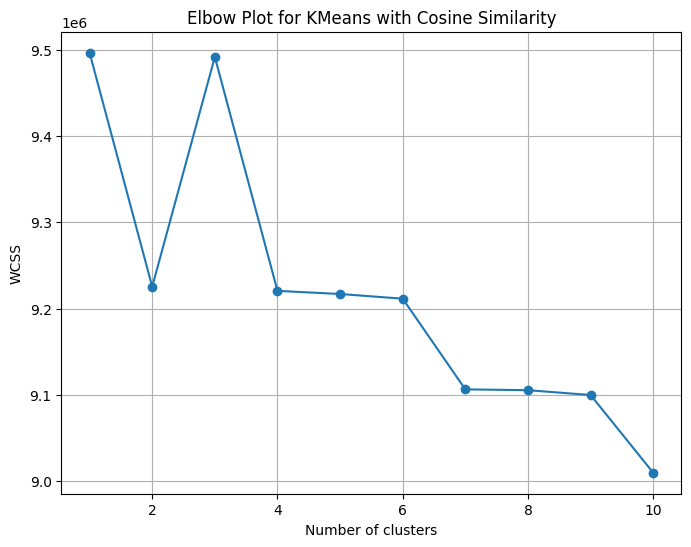

In [9]:
# Kmeas clustering using the cosine similarity
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def kmeans_cosine_elbow(data, max_clusters=10):
    # Calculate cosine similarity matrix using your custom function
    similarity_matrix = np.zeros((len(data), len(data)))  # Initialize similarity matrix
    for i in range(len(data)):
        for j in range(i, len(data)):  # Fill upper triangular matrix for efficiency (avoid duplicates)
            similarity_matrix[i, j] = adjusted_cosine_similarity(data[i], data[j])
            similarity_matrix[j, i] = similarity_matrix[i, j]  # Fill lower triangular matrix for symmetry
    
    # List to store WCSS (Within-Cluster Sum of Squares) for different k values
    wcss = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)  # Set random state for reproducibility
        kmeans.fit(similarity_matrix)
        wcss.append(kmeans.inertia_)  # Inertia represents WCSS
    
    # Elbow plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='-')
    plt.xlabel("Number of clusters")
    plt.ylabel("WCSS")
    plt.title("Elbow Plot for KMeans with Cosine Similarity")
    plt.grid(True)
    plt.show()
    
    # You can observe the elbow point in the plot to determine the optimal k
    
# Example usage (replace with your actual data)
data = list(user_rating_dictionary.values())
kmeans_cosine_elbow(data)


Note that although the clusters don't look all that great in terms of WCSS, our object of making them was to capture macro trends in the data.<br/> Also, since we are using similarity weighted predictions, it's okay in this case that the clusters aren't properly segregated.

In [10]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def kmeans_clustering(data, optimal_k):
    """
    Performs KMeans clustering with the specified k and visualizes the clusters.
    
    Args:
      data: A numpy array representing the user rating dictionaries.
      optimal_k: The chosen optimal number of clusters.
    """
    # Calculate cosine similarity matrix using your custom function (assuming it's defined)
    similarity_matrix = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        for j in range(i, len(data)):
            similarity_matrix[i, j] = adjusted_cosine_similarity(data[i], data[j])
            similarity_matrix[j, i] = similarity_matrix[i, j]
    
    # Perform KMeans clustering with the chosen k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(similarity_matrix)
    
    # Get cluster labels for each data point
    return kmeans.labels_, similarity_matrix

# Create empty lists to store keys and values
top_keys = []
top_values = []

# Loop through the dictionary and add key-value pairs
for key, value in user_rating_dictionary.items():
  # if len(top_keys) < 500:
    top_keys.append(key)
    top_values.append(value)

# Example usage (replace with your actual data and optimal k
optimal_k = 7  # Replace with your actual optimal k value

cluster_labels, similarity_matrix = kmeans_clustering(top_values, optimal_k)

In [11]:
import pickle

with open("./data/similarity_matrix.pkl", "wb") as f:
    pickle.dump(similarity_matrix, f)

In [ ]:
with open('./data/similarity_matrix.pkl', 'rb') as f:
    loaded_similarity_matrix = pickle.load(f)

In [12]:
import pandas as pd

# merge together, top_keys, top_values, and cluster_labels
data_dict = {"userId": top_keys, "movie_rating_dict": top_values, "cluster_id": cluster_labels}
# Create a DataFrame from the dictionary
clustered_df = pd.DataFrame(data_dict)

clustered_df.head()

,userId,movie_rating_dict,cluster_id
0,31,"{1: [3.0, 2015-02-23 23:18:07], 110: [5.0, 201...",1
1,42,"{31: [4.5, 2014-09-25 17:49:26], 111: [4.0, 20...",1
2,71,"{318: [5.0, 2014-12-01 17:13:35], 356: [5.0, 2...",3
3,85,"{17: [4.5, 2014-05-18 15:52:06], 262: [4.5, 20...",3
4,96,"{47: [4.0, 2015-01-18 04:07:27], 293: [4.5, 20...",6


In [13]:
import pickle

with open("./data/clustered_data.pkl", "wb") as f:
    pickle.dump(clustered_df, f)

In [ ]:
with open('./data/clustered_data.pkl', 'rb') as f:
    clustered_df = pickle.load(f)

In [31]:
new_user_ratings = {2:2, 29:4, 242:1, 6:4}
# predicted_cluster = kmeans_model.predict(new_user_ratings)

# Find most similar user in training data (assuming similarity scores are stored somewhere)
most_similar_user_index = np.argmax(similarity_matrix, axis=0)  # Find index of max similarity
# Predict cluster label based on most similar user's cluster
predicted_cluster = clustered_df.loc[most_similar_user_index, 'cluster_id'].iloc[0]
recommendations = {}

# Need to recommend high rated movies from the same cluster.
# Filter out all entries from a particular cluster
single_cluster_df = clustered_df[clustered_df['cluster_id'] == predicted_cluster]

# Create a priority list of the (on average) highest rated movies in that cluster
# Need to create a dictionary from the rating values in that cluster.
cluster_size = len(single_cluster_df)
result_dict = {}
for index, row in clustered_df.iterrows():
    similarity_score = adjusted_cosine_similarity(row['movie_rating_dict'], new_user_ratings, min_ratings=1)
    for movieId, rating in row['movie_rating_dict'].items():
        if movieId not in result_dict:
            result_dict[movieId] = {
                "sum_similarity_rating": 0,
                "sum_similarity": 0
            }
        result_dict[movieId]["sum_similarity_rating"] += similarity_score*rating
        result_dict[movieId]["sum_similarity"] += similarity_score

        if result_dict[movieId]["sum_similarity"] == 0:
            net_score = 0
        else:
            net_score = result_dict[movieId]["sum_similarity_rating"]/result_dict[movieId]["sum_similarity"]
        recommendations[movieId] = net_score

In [32]:
# Sort the dictionary by values (scores) in descending order
sorted_movies = dict(sorted(recommendations.items(), key=lambda item: item[1], reverse=True))

# Get the top 5 movie names (keys)
top_5_movies = list(sorted_movies.keys())[:5]

print(top_5_movies)

[234, 3917, 1797, 762, 2688]


In [7]:
# Get the movie names
import pandas as pd

data_path = "./data/movie.csv"
movie_df = pd.read_csv(data_path)
print(movie_df.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [8]:
len(movie_df)

27278

In [19]:
movie_df = movie_df.set_index('movieId')
for movie in [1, 2]:
    print(movie_df.iloc[movie]["title"])

Jumanji (1995)
Grumpier Old Men (1995)


In [26]:
recommendations.items()

dict_items([(123, 43), (403, 40), (999, 223), (543, 222), (666, 1)])

In [29]:
recommendations = {
    126 : 90,
    403: 40,
    123: 43,
    999: 223,
    543: 222,
    666: 1,
}

sorted_movies = dict(sorted(recommendations.items(), key=lambda item: item[1], reverse=True))
print(sorted_movies)
print(list(sorted_movies.keys()))
# Fetching top 5 movies
top_5_movies = list(sorted_movies.keys())[:5]

{999: 223, 543: 222, 126: 90, 123: 43, 403: 40, 666: 1}
[999, 543, 126, 123, 403, 666]


In [30]:
top_5_movies

[999, 543, 126, 123, 403]

### Streamlit

In [19]:
import streamlit as st
import pandas as pd

# Sample movie data (replace with your actual data source)
movies = pd.DataFrame({
    "title": ["Movie A", "Movie B", "Movie C", "Movie D", "Movie E"],
    "genre": ["Action", "Comedy", "Romance", "Sci-Fi", "Thriller"]
})

# User input dictionary (initially empty)
user_ratings = {}

def recommend_movies(user_ratings, movies):
  """
  Recommends movies based on cosine similarity between user ratings and movie data.

  Args:
      user_ratings: A dictionary storing user ratings for movie IDs (key) and ratings (value).
      movies: A pandas DataFrame containing movie information (title, genre, etc.).

  Returns:
      A list of top N recommended movie titles.
  """

  # Create a DataFrame from user ratings (assuming movie IDs are unique)
  user_ratings_df = pd.DataFrame.from_dict(user_ratings, orient='index', columns=['rating'])

  # Calculate cosine similarity between user ratings and movie data (assuming movie IDs are the same)
  similarity_matrix = cosine_similarity(user_ratings_df, movies)

  # Get average rating for each movie (optional, for filtering)
  average_ratings = movies.groupby('title')['rating'].transform('mean')

  # Select top N movies with high similarity and (optional) above average rating
  N = 5  # Number of recommendations
  recommendations = similarity_matrix.iloc[0].sort_values(ascending=False).head(N).index[similarity_matrix.iloc[0] > 0.5]  # Filter by minimum similarity threshold
  recommendations = recommendations[recommendations.isin(average_ratings[average_ratings > user_ratings_df.iloc[0]['rating']].index)]  # Optional filtering by average rating

  return list(recommendations)

st.title("Movie Recommendation App")

# User input section
movie_select = st.selectbox("Select a movie you've seen:", movies["title"].to_list())
rating_select = st.slider("Rate the movie:", 1, 5, 1)

if st.button("Submit Rating"):
  user_ratings[movies[movies["title"] == movie_select].iloc[0]["title"]] = rating_select

# Recommendation section
if user_ratings:
  recommendations = recommend_movies(user_ratings, movies.copy())
  st.subheader("Recommended Movies for You:")
  for movie in recommendations:
    st.write(movie)
else:
  st.write("Rate some movies to get recommendations!")



2024-05-27 13:54:49.317 
  command:

    streamlit run D:\AiEngineer\Projects\PortfolioProjects\MovieRecommendationSystem\recommend_env\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-05-27 13:54:49.317 Session state does not function when running a script without `streamlit run`


In [1]:
# Saving the dependencies in a compressed state
import pickle
import gzip

with open('./data/similarity_matrix.pkl', 'rb') as f:
    similarity_matrix = pickle.load(f)

# Compress and pickle
with gzip.open("./project_data/similarity_matrix.pkl.gz", "wb") as f:
    pickle.dump(similarity_matrix, f)


In [2]:
# Decompress and unpickle
with gzip.open("./project_data/similarity_matrix.pkl.gz", "rb") as f:
    similarity_matrix = pickle.load(f)

In [3]:
print(len(similarity_matrix))

9148


In [4]:
# Saving the dependencies in a compressed state
import pickle
import gzip

with open('./data/clustered_data.pkl', 'rb') as f:
    clustered_data = pickle.load(f)

print(len(clustered_data))

# Compress and pickle
with gzip.open("./project_data/clustered_data.pkl.gz", "wb") as f:
    pickle.dump(clustered_data, f)

9148


In [5]:
# Decompress and unpickle
with gzip.open("./project_data/clustered_data.pkl.gz", "rb") as f:
    clustered_data = pickle.load(f)

print(len(clustered_data))

9148
